In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, BatchNormalization, Concatenate, Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from matplotlib.widgets import SpanSelector
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

In [124]:
df_train = pd.read_csv("/content/drive/MyDrive/Ml-twitter/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Ml-twitter/test.csv")
df_train = df_train.dropna()
df_train.shape
df_train.head(10)
df_train.dtypes
df_train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [125]:
df_test

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


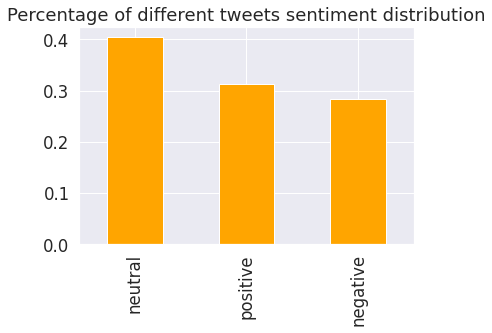

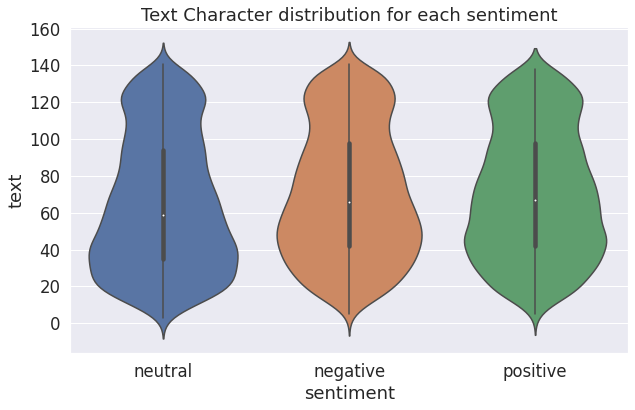

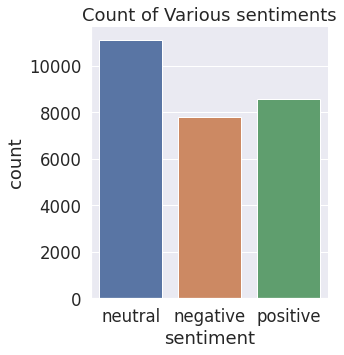

In [127]:
#EDA
sns.set(font_scale=1.5)
d = {'color': ['r', 'b',]}
df_train['sentiment'].value_counts(normalize= True).plot.bar(color = 'orange').set_title("Percentage of different tweets sentiment distribution")
_, plt2 = plt.subplots(figsize=(10, 6))

sns.catplot(x='sentiment', kind = "count", data=df_train, ax = plt2).set(title = 'Count of Various sentiments');
sns.violinplot(x='sentiment', y = df_train.text.str.len(), data=df_train, ax = plt2).set(title = 'Text Character distribution for each sentiment');


In [128]:
# function to remove all character and URL'S except whitespace, space, star, comma and apostrophe
import re
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text = re.sub(r'[^\w\s\*\'\,]+', '', text) 
    text = re.sub(r"http\S+", "", text)
    return text

In [129]:
df_train['text'] = df_train['text'].apply(lambda x: preprocess(x))
df_train['selected_text'] = df_train['selected_text'].apply(lambda x: preprocess(x))
df_train = df_train.dropna()

In [130]:
df_test['text'] = df_test['text'].apply(lambda x: preprocess(x))
df_test['text'] = df_test['text'].replace(r'^s*$', float('NaN'), regex = True)
df_test.dropna(subset = ["text"], inplace=True)
text_length = df_test['text'].apply(lambda x: len(str(x).split()))
if 'text_len' not in df_test:
    df_test.insert(3, 'text_len', text_length)

For test data from test CSV file remove the special character similar to the way it has been removed in train dataset then create a text_length column

In [131]:
# replace all empty values with NaN
df_train['text'] = df_train['text'].replace(r'^s*$', float('NaN'), regex = True)
df_train['selected_text'] = df_train['selected_text'].replace(r'^s*$', float('NaN'), regex = True)
df_train.dropna(subset = ["text", "selected_text"], inplace=True)
text_length = df_train['text'].apply(lambda x: len(str(x).split()))
selected_text_length = df_train['selected_text'].apply(lambda x: len(str(x).split()))
if 'text_len' not in df_train and 'selected_text_len' not in df_train:
    df_train.insert(2, 'text_len', text_length)
    df_train.insert(4, 'selected_text_len', selected_text_length)
df_train

,textID,text,text_len,selected_text,selected_text_len,sentiment
0,cb774db0d1,"id have responded, if i were going",7,"id have responded, if i were going",7,neutral
1,549e992a42,sooo sad i will miss you here in san diego,10,sooo sad,2,negative
2,088c60f138,my boss is bullying me,5,bullying me,2,negative
3,9642c003ef,what interview leave me alone,5,leave me alone,3,negative
4,358bd9e861,"sons of ****, why couldnt they put them on the...",14,"sons of ****,",3,negative
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband lo...,16,d lost,2,negative
27477,4f4c4fc327,ive wondered about rake to the client has mad...,23,", dont force",3,negative
27478,f67aae2310,yay good for both of you enjoy the break you ...,21,yay good for both of you,6,positive
27479,ed167662a5,but it was worth it ****,6,but it was worth it ****,6,positive


In [132]:
# function to get the start and end index of the selected text
def get_start_end_index(col):
    text, sel_text = col[0], col[1]
    text_val = text.split()
    sel_text = sel_text.split()
    index_start = sel_text[0]
    index_end = sel_text[-1]
    if index_start in text_val and index_end in text_val:
      index_start = text_val.index(sel_text[0])
      index_end = text_val.index(sel_text[-1])
    else:
      index_start = -1
      index_end = -1
    return index_start, index_end

In [133]:
df_train['indices'] = df_train[['text','selected_text']].apply(lambda x:get_start_end_index(x),axis=1)
df_train[['start_index','end_index']] = df_train['indices'].astype(str).str.replace('(','').str.replace(')','').str.split(',', expand= True)
df_train = df_train.drop(['indices'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Dropping those indices where start and end index of selected text is not present inside text column

In [134]:
df_train = df_train[(df_train.start_index.astype(int) >-1) & (df_train.end_index.astype(int) > -1)]
df_train['start_index'] = df_train['start_index'].astype(str).astype(int)
df_train['end_index'] = df_train['end_index'].astype(str).astype(int)
df_train.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


textID               object
text                 object
text_len              int64
selected_text        object
selected_text_len     int64
sentiment            object
start_index           int64
end_index             int64
dtype: object

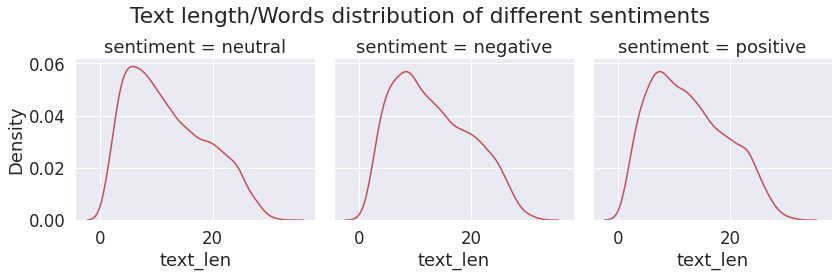

In [135]:
d = {'color': ['r']}
sns.set(font_scale=1.5)
g=sns.FacetGrid(data=df_train,col='sentiment',height=4, hue_kws= d);
g.map(sns.kdeplot,'text_len');
plt.subplots_adjust(top=0.80)
g.fig.suptitle('Text length/Words distribution of different sentiments');

Exploratory Data Analysis of Original sentence(text column) and words count for differnt sentiments .
Majority of the tweets text word fall in range 15 to 25 for all sentiment categories. For all sentiment categories, only few tweets of text word counts greater than 30 or less than 5.
Maximum words for the longest tweet is 33, while minimum is 2.

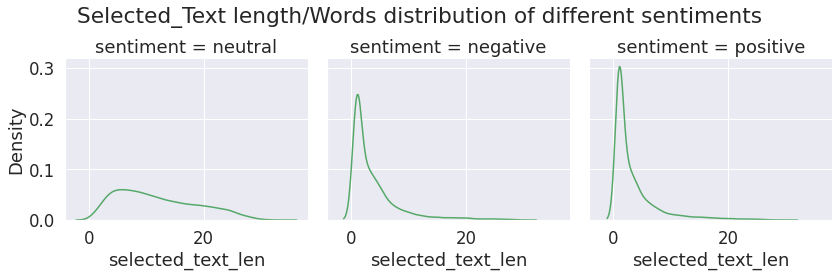

In [136]:
d = {'color': ['g']}
g=sns.FacetGrid(data=df_train,col='sentiment',height=4, hue_kws= d);
g.map(sns.kdeplot,'selected_text_len');
plt.subplots_adjust(top=0.80)
g.fig.suptitle('Selected_Text length/Words distribution of different sentiments');

Neutral tweets are mostly lying in range [2 to 15] while positive and negative tweets are in range [2 to 5].
For positive and negative sentiment categories, only few tweets of text word counts greater than 10.
Neutral tweets text words are counting up to 30, very few sentence text words are going beyond 30.

In [137]:
X = df_train[['text','sentiment']]
y = df_train[['start_index','end_index']]

# for test data
X_test_testdata = df_test[['text','sentiment']]

In [138]:
# train test split and validation split
X_train, X_test, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state= 1)
X_train_v, X_val, ytrain_v, yval = train_test_split(X_train, ytrain, test_size= 0.2)

In [139]:
def get_train_val_split():
    train_text = X_train_v['text'].values.astype(str)
    val_text = X_val['text'].values.astype(str)
    train_sentiment = X_train_v['sentiment'].values.astype(str)
    val_sentiment = X_val['sentiment'].values.astype(str)
    return train_text, val_text, train_sentiment, val_sentiment

In [140]:
max_length_text = df_train['text_len'].max() #33
max_length_text_test = df_test['text_len'].max() # 32
max_length_sentiment= 1
def convert_to_Vector(input_text_sen, input_val_sen, max_length_text_sen):
    t_text_sentiment = Tokenizer(lower=True,split=' ',oov_token='oov')
    t_text_sentiment.fit_on_texts(input_text_sen)
    input_text_sen = t_text_sentiment.texts_to_sequences(input_text_sen)
    input_val_sen = t_text_sentiment.texts_to_sequences(input_val_sen)
    input_text_sen = pad_sequences(input_text_sen, maxlen=max_length_text_sen,padding='post')
    input_val_sen = pad_sequences(input_val_sen, maxlen=max_length_text_sen,padding='post')
    return input_text_sen,input_val_sen, t_text_sentiment

train_text, val_text, train_sentiment, val_sentiment = get_train_val_split()
train_text,val_text, t_text = convert_to_Vector(train_text, val_text, max_length_text)
train_sentiment,val_sentiment, t_sentiment = convert_to_Vector(train_sentiment, val_sentiment, max_length_sentiment)

Transforming the text into integers and padding them to equal length. As we are dealing with text column which contains words/texts from different tweets. Also each data point is going to be of distinctive lengths. Therefore, conversion of text data into number is required and after that we are padding all the data points to have the similarity between the length of input.

using **fit_on_text**, **texts_to_sequences** and **pad_sequences** for converting the texts into number with similar length.

used **'oov'** out of vocubalry tokenizer to get some token value for non existence text



In [141]:
def getvocab(input_text_sen, input_val_sen, t_text_sentiment):
    vocab_text_sen=len(t_text_sentiment.word_index)+1
    return vocab_text_sen

vocab_text = getvocab(train_text, val_text, t_text)
print(vocab_text)
vocab_sentiment = getvocab(train_sentiment, val_sentiment, t_sentiment)
print(vocab_sentiment)

20008
5


In [142]:
#max length of sentence
print("max length of train data selected senetence is: ", df_train['selected_text'].apply(len).max())


max length of train data selected senetence is:  138


In [143]:
from numpy import asarray
from numpy import zeros
embeddings_index = dict()
f = open('/content/drive/MyDrive/Ml-twitter/glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400001 word vectors.


Glove works on computing a file mapping words to known embeddings called as glove record. It parses the data dump of pre-trained embeddings vectors.

We are going to take both sentiment and text as input, therefore we are tranforming both of them into embeding matrix

In [144]:
embedding_matrix = zeros((vocab_text, 300))
for word, index in t_text.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(20008, 300)


Getting embedding vector for test column, The embedding layer comprises of an embedding vector matrix, this matrix  contains a high-dimensional representation of a specific word, and these word is present in our training data

In [145]:
embedding_matrix_sentiment = zeros((vocab_sentiment, 300))
for word, index in t_sentiment.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_sentiment[index] = embedding_vector

print(embedding_matrix_sentiment.shape)

(5, 300)


Getting embedding vector for sentiment column.

In [146]:
trainX = (train_text,train_sentiment)
trainy = ytrain_v.values.astype(int)

valX = (val_text, val_sentiment)
valy = yval.values
val_data = (valX,valy)

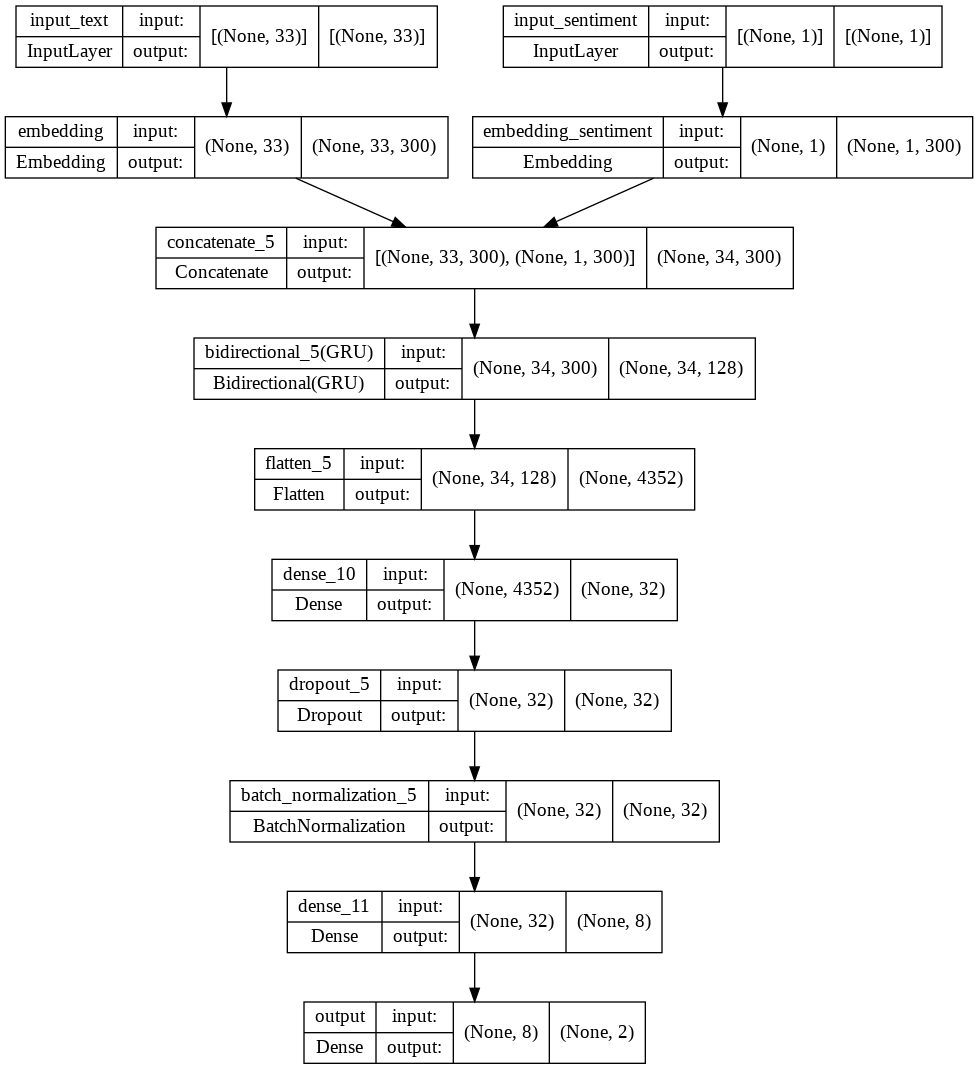

In [151]:
inputlayer1_text=Input(shape=(max_length_text,),name='input_text')
embed1 = Embedding(vocab_text,300,input_length=max_length_text,name='embedding',\
                      trainable=False,embeddings_initializer=tf.constant_initializer(embedding_matrix))(inputlayer1_text)
inputlayer2_sentiment = Input(shape=(1,),name='input_sentiment')
embed2=Embedding(vocab_sentiment,300,input_length= max_length_sentiment,name='embedding_sentiment',\
                 trainable=False,embeddings_initializer=tf.constant_initializer(embedding_matrix_sentiment))(inputlayer2_sentiment)

concat=Concatenate(axis=1)([embed1, embed2])
gru= Bidirectional(GRU(64,name='GRU', return_sequences=True))(concat)
f1=Flatten()(gru)
denselayer1 = Dense(32,activation='relu',kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.0001))(f1)
droplayer1 = Dropout(0.5)(denselayer1)
ln= BatchNormalization()(droplayer1)
denselayer2=Dense(8,activation='relu',kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.0001))(ln)
output=Dense(2,name='output')(denselayer2)
model=Model(inputs=[inputlayer1_text, inputlayer2_sentiment],outputs=[output])

plot_model(model, to_file='model_plot_twitter_sentiment.png', show_shapes=True, show_layer_names=True)

The plotted model is the architecture of the GRU model with two input layer text and sentiment which is transformed into embedding layer and then concatenated. Later on We are feeding this layer to bi-rectional GRU which will be flatten and using two different hidden layer we are reaching to output layer with 2 output units

In [152]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text (InputLayer)        [(None, 33)]         0           []                               
                                                                                                  
 input_sentiment (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 300)      6002400     ['input_text[0][0]']             
                                                                                                  
 embedding_sentiment (Embedding  (None, 1, 300)      1500        ['input_sentiment[0][0]']        
 )                                                                                          

In [153]:
model.compile(optimizer='adam',loss="mse",metrics=["accuracy"])
mc = ModelCheckpoint('best_model_twiter.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)

In [154]:
history = model.fit(trainX,trainy,epochs=200,batch_size=256,validation_data=val_data,validation_batch_size=128, callbacks=[es, mc])

Epoch 1/200
63/64 [============================>.] - ETA: 0s - loss: 56.6396 - accuracy: 0.6757
Epoch 1: val_accuracy improved from -inf to 0.70167, saving model to best_model_twiter.h5
64/64 [==============================] - 13s 148ms/step - loss: 56.5862 - accuracy: 0.6763 - val_loss: 47.0835 - val_accuracy: 0.7017
Epoch 2/200
63/64 [============================>.] - ETA: 0s - loss: 37.7567 - accuracy: 0.6986
Epoch 2: val_accuracy did not improve from 0.70167
64/64 [==============================] - 2s 35ms/step - loss: 37.6814 - accuracy: 0.6992 - val_loss: 26.3098 - val_accuracy: 0.6627
Epoch 3/200
63/64 [============================>.] - ETA: 0s - loss: 22.0240 - accuracy: 0.7215
Epoch 3: val_accuracy improved from 0.70167 to 0.72915, saving model to best_model_twiter.h5
64/64 [==============================] - 7s 108ms/step - loss: 21.9435 - accuracy: 0.7210 - val_loss: 16.6183 - val_accuracy: 0.7291
Epoch 4/200
63/64 [============================>.] - ETA: 0s - loss: 15.1699 - 

# Hypertuning Parameter
Tried combination 

kernel_initializer  |Epochs   | batch_size  | validation_batch_size
--------------------|---------|-------------|-------------------
"he_normal", "uniform", "glorot_uniform     | 80,200 | 128,256,512   | 64,128


Got the best accuracy for "glorot_uniform" with 200 epochs , earlystopping at 80 and batch size 256 with validation size 64

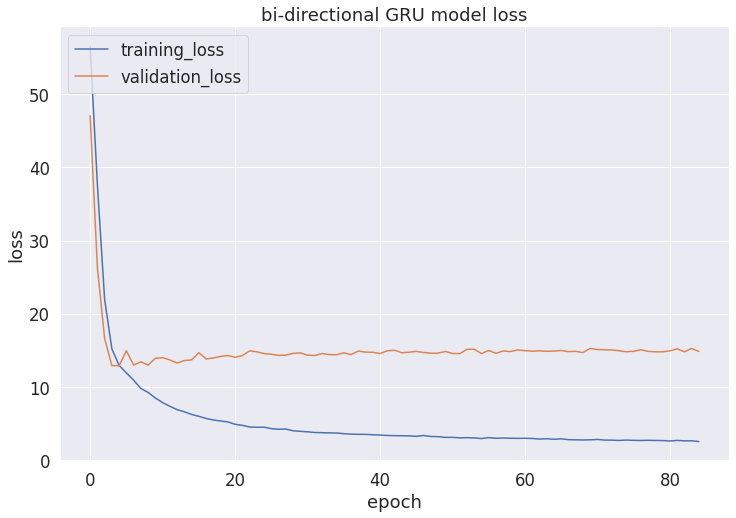

In [155]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('bi-directional GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper left')
plt.show()

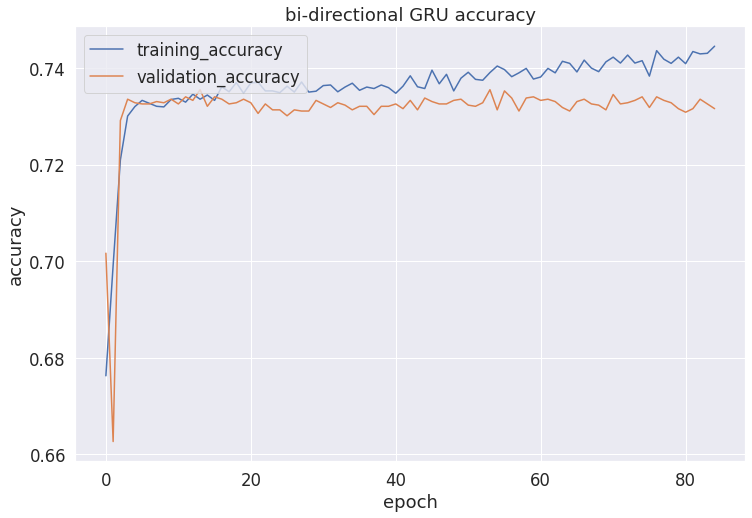

In [156]:
plt.figure(figsize = (12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('bi-directional GRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_accuracy', 'validation_accuracy'], loc='upper left')
plt.show()

In [157]:
saved_model = load_model('best_model_twiter.h5')

In [158]:
# test data from training set
def define_test_set(test_val, text_max_len):
    test_text = test_val['text'].values.astype(str)
    test_text = t_text.texts_to_sequences(test_text)
    test_text = pad_sequences(test_text,maxlen=text_max_len,padding='post')

    test_sentiment = test_val['sentiment'].values.astype(str)
    test_sentiment= t_sentiment.texts_to_sequences(test_sentiment)
    test_sentiment = pad_sequences(test_sentiment,maxlen=max_length_sentiment,padding='post')
    return test_text, test_sentiment

test_text_tr, test_sentiment_tr = define_test_set(X_test, max_length_text) # test dataframe from train data only
test_text_testdata, test_sentiment_testdata = define_test_set(X_test_testdata, max_length_text) # test dataframe from test CSV file

In [159]:
# result from training data
result_tr  = model.predict([test_text_tr, test_sentiment_tr])
result_tr = np.round(result_tr)

In [160]:
# result from test data from test csv
result_testdata = model.predict([test_text_testdata, test_sentiment_testdata])
result_testdata = np.round(result_testdata)

In [161]:
# function to get the text based on start and end indices
def find_sel_text(x):
  txt , start , end = x[0],x[1],x[2]
  end=end+1
  txt = txt.split()
  sel_text = txt[start:end]
  sel_text = " ".join(sel_text)
  return sel_text

In [162]:
def ypred_dataframe_tr(results, testframe):
    ypred = testframe.iloc[:,:]
    ypred['pred_st_index'], ypred['pred_en_index'] = (abs(results[:,0])),(abs(results[:,1]))
    ypred['pred_st_index'] = ypred['pred_st_index'].astype('int')
    ypred['pred_en_index'] = ypred['pred_en_index'].astype('int')
    ypred['predicted_text'] = ypred[["text","pred_st_index","pred_en_index"]].apply(lambda x: find_sel_text(x), axis = 1)

    ytest['text'] = ypred["text"]
    ypred['selected_text'] = ytest[["text","start_index","end_index"]].apply(lambda x: find_sel_text(x), axis = 1)
    return ypred

ypred_tr = ypred_dataframe_tr(result_tr, X_test)

In [163]:
def ypred_dataframe_testdata(results, testframe):
    ypred = testframe.iloc[:,:]
    ypred['pred_st_index'], ypred['pred_en_index'] = (abs(results[:,0])),(abs(results[:,1]))
    ypred['pred_st_index'] = ypred['pred_st_index'].astype('int')
    ypred['pred_en_index'] = ypred['pred_en_index'].astype('int')
    ypred['predicted_text'] = ypred[["text","pred_st_index","pred_en_index"]].apply(lambda x: find_sel_text(x), axis = 1)
    return ypred

ypred_testdata = ypred_dataframe_testdata(result_testdata, X_test_testdata)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [164]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0):
        return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [165]:
ypred_tr

,text,sentiment,pred_st_index,pred_en_index,predicted_text,selected_text
10064,now i want ice cream but its so expensive,negative,4,9,cream but its so expensive,so expensive
24548,hi nancy your fine till it the baby moves jus...,neutral,0,25,hi nancy your fine till it the baby moves just...,hi nancy your fine till it the baby moves just...
7452,make sure u pick up chrisette micheles new alb...,positive,17,19,love it promise,congrats
17367,waiting for princes protection program online ...,neutral,0,11,waiting for princes protection program online ...,waiting for princes protection program online ...
7960,found out i have to go to the us again in augu...,negative,17,18,not good,getting tired of transatlantic flights not goo...
...,...,...,...,...,...,...
1031,i feel really bad for female racoons with abus...,negative,8,10,abusive racoon husbands,bad
23019,afc oh yess,positive,1,2,oh yess,oh yess
8134,_in i loved that movie and i miss raul julia,neutral,0,7,_in i loved that movie and i miss,_in i loved that movie and i miss raul julia
15482,hi found you through i am indeed a pigment o...,neutral,0,11,hi found you through i am indeed a pigment of ...,hi found you through i am indeed a pigment of ...


The **Jaccard Score** or Jaccard Similarity is one of the statistics used in understanding the similarity between two sets.

In [166]:
def get_jaccard_score(ypred):
    ypred['jaccard_score'] = ypred.apply(lambda x: jaccard(x.selected_text, x.predicted_text), axis = 1)
    return np.mean(ypred_tr['jaccard_score'])

jaccard_score_tr = get_jaccard_score(ypred_tr)
print("Mean Jaccard Index score for unseen test data taken from training set: %.5f" % jaccard_score_tr)

Mean Jaccard Index score for unseen test data taken from training set: 0.53233


In [168]:
ypred_testdata

,text,sentiment,pred_st_index,pred_en_index,predicted_text
0,last session of the day,neutral,1,4,session of the day
1,shanghai is also really exciting precisely sk...,positive,6,6,skyscrapers
2,"recession hit veronique branquinho, she has to...",negative,10,11,such a
3,happy bday,positive,0,1,happy bday
4,i like it,positive,1,2,like it
...,...,...,...,...,...
3529,"its at 3 am, im very tired but i cant sleep b...",negative,5,6,very tired
3530,all alone in this old house again thanks for ...,positive,15,18,and kicking whoever invented
3531,i know what you mean my little dog is sinking ...,negative,11,12,depression he
3532,_sutra what is your next youtube video gonna b...,positive,10,11,i love


#Predicted text for Test CSV data

In [169]:
ypred_train = model.predict(trainX)

In [170]:
print("Mean square error is %.5f" % mean_squared_error(ypred_train, trainy))

Mean square error is 1.22858
